## Setup

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
from td.client import TDClient
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV,\
    cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from functions import *
%matplotlib inline
pd.set_option('display.max_columns',None)

In [8]:
df = pd.read_csv('../data/cmc.data', names = ['age','edu','hus_edu','chil','rel','work',
                                        'hus_ocu','sol','media','cmc'])

In [9]:
df.cmc.value_counts()

1    629
3    511
2    333
Name: cmc, dtype: int64

# EDA

In [10]:
X = df.copy()
y = X.pop('cmc')

In [11]:
def feature_plot(df, ind, dep, plot_type, xlabel, xlog = 'n', ylog = 'n', color = u'#1f77b4'):
    ylabel = f'Contraception Method'
    title = f'{ylabel} vs {xlabel}'
    file_name = f'{xlabel}.png'
    fig, ax = plt.subplots(figsize = [12,8])
    if plot_type == 'scatter':
        sns_obj = sns.scatterplot(data = df, x=ind, y=dep, ax=ax, color = color)
    elif plot_type == 'line':
        sns_obj = sns.lineplot(data = df, x=ind, y=dep, color = color)
    if xlog == 'y':
        set_x_log(sns_obj, ax)
    if ylog == 'y':
        set_y_log(sns_obj, ax)
    # what color is u'#1f77b4'? what color is None?
    ax.set_title(title, fontdict = {'fontsize': 14})
    ax.set_xlabel(xlabel, fontdict = {'fontsize': 12})
    ax.set_ylabel(ylabel, fontdict = {'fontsize': 12})
    plt.savefig(f'../images/{file_name}')

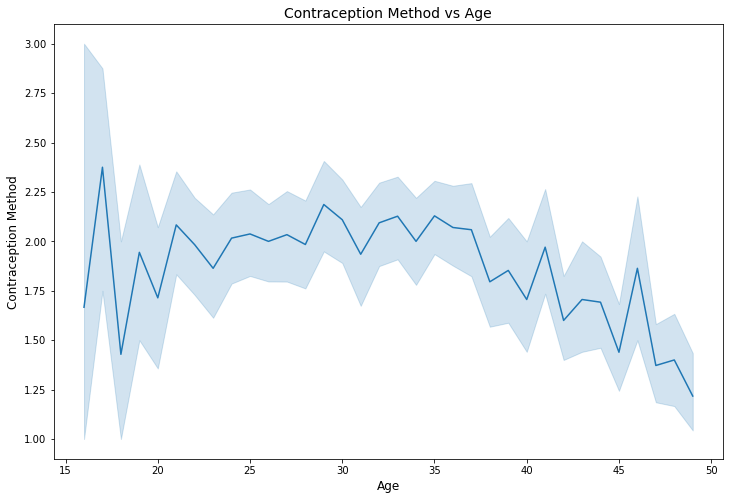

In [12]:
feature_plot(df, df.age, y, 'line', 'Age', xlog = 'n', ylog = 'n', color = u'#1f77b4')

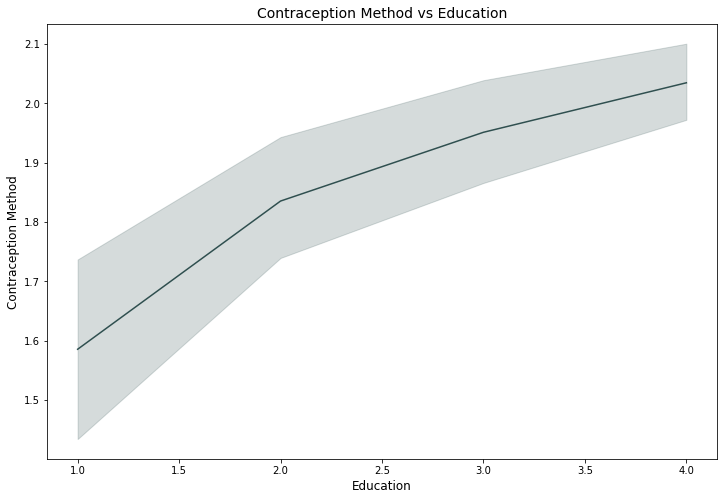

In [13]:
feature_plot(df, df.edu, y, 'line', 'Education', color = 'darkslategray')

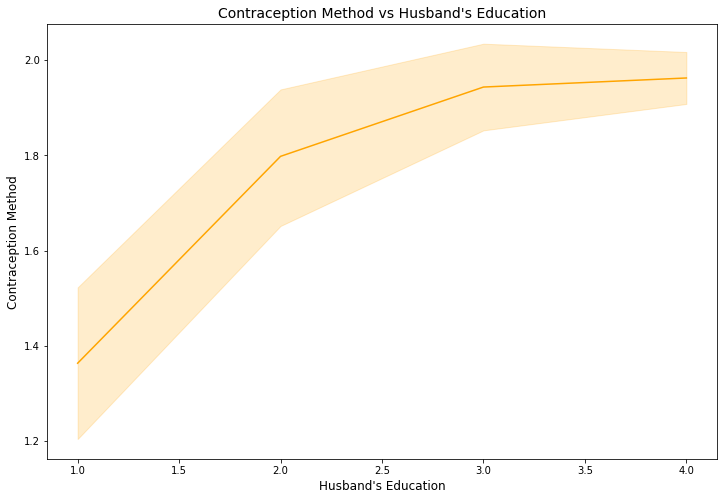

In [14]:
feature_plot(df, df.hus_edu, y, 'line', 'Husband\'s Education', color = 'orange')

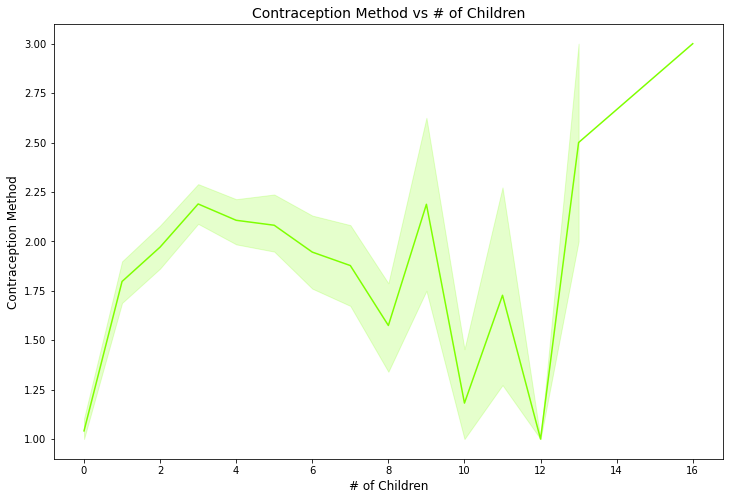

In [15]:
feature_plot(df, df.chil, y, 'line', '# of Children', color = 'chartreuse')

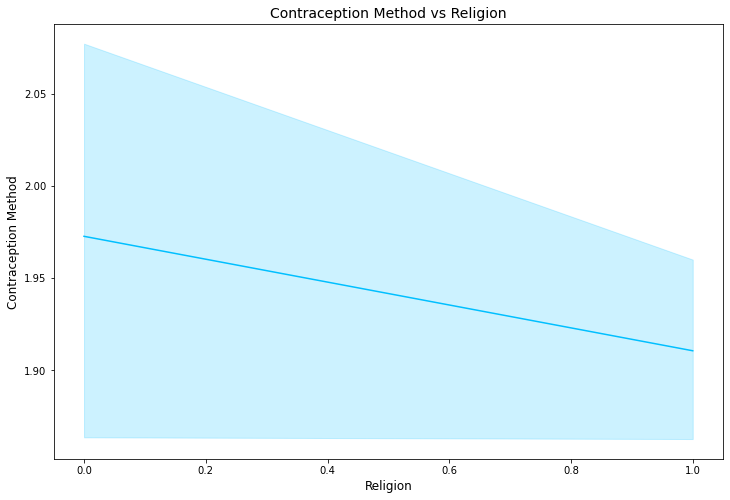

In [16]:
feature_plot(df, df.rel, y, 'line', 'Religion', color = 'deepskyblue')

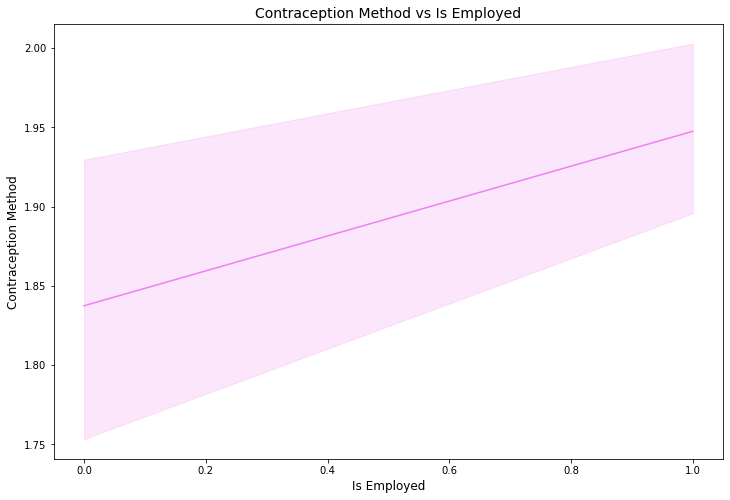

In [17]:
feature_plot(df, df.work, y, 'line', 'Is Employed', color = 'violet')

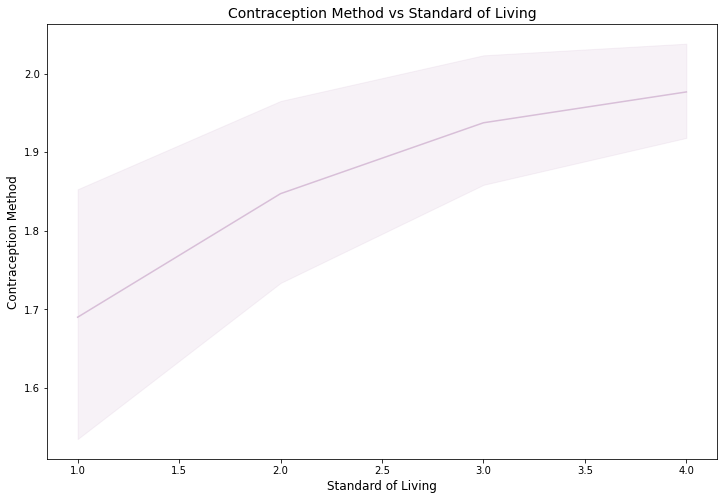

In [18]:
feature_plot(df, df.sol, y, 'line', 'Standard of Living', color = 'thistle')

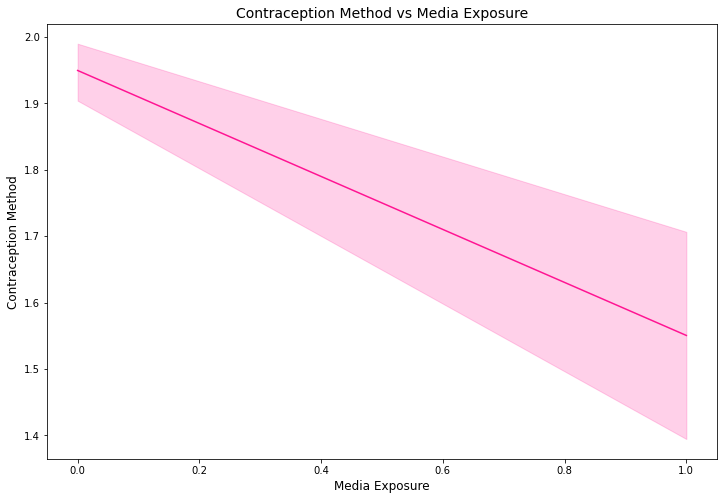

In [19]:
feature_plot(df, df.media, y, 'line', 'Media Exposure', color = 'deeppink')

49 0.16295261509293898


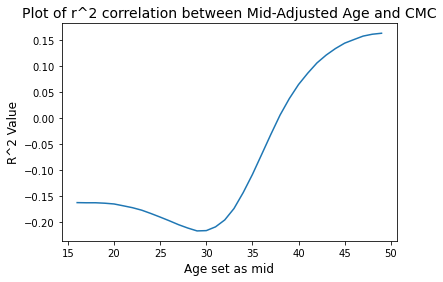

In [20]:
df_age = df.copy()
r_values = {}
ages = range(df_age.age.min(), df_age.age.max() + 1)
for age in ages:
    df_age['age_mid'] = np.abs(df_age['age'] - age)
    r_values[age] = df_age['age_mid'].corr(df_age.cmc)
fig, ax = plt.subplots()
ax.plot(*zip(*sorted(r_values.items())))
ax.set_title('Plot of r^2 correlation between Mid-Adjusted Age and CMC', fontdict = {'fontsize': 14})
ax.set_xlabel('Age set as mid', fontdict = {'fontsize': 12})
ax.set_ylabel('R^2 Value', fontdict = {'fontsize': 12})
print(max(r_values, key=r_values.get), max(r_values.values()))

This tells us there is no midpoint age at which to bifurcate the data.

0 0.08277224205909448


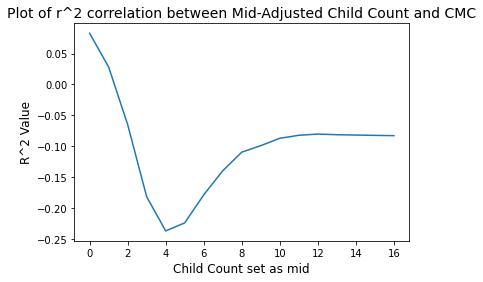

In [21]:
df_child = df.copy()
r_values = {}
childs = range(df_child.chil.min(), df_child.chil.max() + 1)
for child in childs:
    df_child['chil_mid'] = np.abs(df_child.chil - child)
    r_values[child] = df_child['chil_mid'].corr(df_child.cmc)
fig, ax = plt.subplots()
ax.plot(*zip(*sorted(r_values.items())))
ax.set_title('Plot of r^2 correlation between Mid-Adjusted Child Count and CMC', fontdict = {'fontsize': 14})
ax.set_xlabel('Child Count set as mid', fontdict = {'fontsize': 12})
ax.set_ylabel('R^2 Value', fontdict = {'fontsize': 12})
print(max(r_values, key=r_values.get), max(r_values.values()))

This tells us there is no midpoint child count at which to bifurcate the data.

# Data Preparation

## Dummying

In [22]:
to_dummy = ['edu', 'hus_edu', 'chil', 'hus_ocu', 'sol']
X_with_dums = pd.get_dummies(X, columns=to_dummy, drop_first=True)
# X_with_dums = pd.get_dummies(df, columns=to_dummy)
X_with_dums.shape

(1473, 30)

## Split data into train and test sets

In [23]:
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_with_dums, y, test_size=.25,
    random_state=1)
X_train_df.shape

(1104, 30)

## Scale features

In [24]:
rs = RobustScaler()

rs.fit(X_train_df)
X_train = rs.transform(X_train_df)
X_test = rs.transform(X_test_df)

# Modeling

## Logistic Regression - Base Model

Classifier:  LogisticRegression
Num features:  30
Model score:  0.5718157181571816
Accuracy score:  0.5718157181571816
Model F1 (micro):  0.5718157181571816
Model F1 (macro):  0.5405777690559126
Model F1 (weighted):  0.5660858901627333
Cross validation score:  [0.60810811 0.52702703 0.58108108 0.48648649 0.52054795]
Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.69      0.68       161
           2       0.59      0.33      0.43        87
           3       0.46      0.59      0.52       121

    accuracy                           0.57       369
   macro avg       0.57      0.54      0.54       369
weighted avg       0.58      0.57      0.57       369

One-vs-One ROC AUC scores:
0.753431 (macro),
0.756977 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.758908 (macro),
0.760028 (weighted by prevalence)


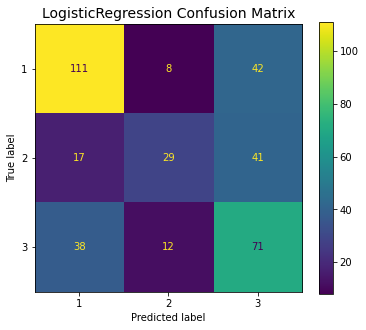

In [25]:
lr_base_clf = LogisticRegression(multi_class='multinomial', max_iter=1000)
lr_base_clf.fit(X_train, y_train)
model_stats(X_train_df.columns, lr_base_clf, 'LogisticRegression', X_test, y_test)

We will investigate whether to dummy `children`.

## Logistic Regression w/ Children dummied

{'lr__C': 78.47599703514607, 'lr__class_weight': 'balanced', 'lr__dual': True, 'lr__l1_ratio': 0.0001, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Classifier:  LogisticRegression
Num features:  30
Model score:  0.5501355013550135
Accuracy score:  0.5501355013550135
Model F1 (micro):  0.5501355013550135
Model F1 (macro):  0.5352941467738181
Model F1 (weighted):  0.5494776055323054
Cross validation score:  [0.43243243 0.5        0.55405405 0.54054054 0.45205479]
Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.59      0.63       149
           2       0.51      0.39      0.44        93
           3       0.47      0.62      0.54       127

    accuracy                           0.55       369
   macro avg       0.55      0.53      0.54       369
weighted avg       0.56      0.55      0.55       369

One-vs-One ROC AUC scores:
0.753592 (macro),
0.756264 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.757842 (macro),
0.

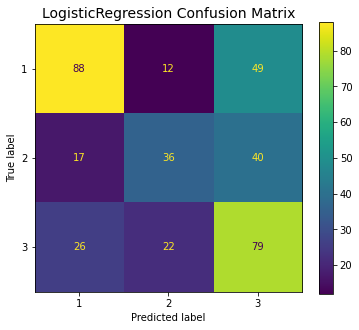

In [26]:
to_dummy = ['edu', 'hus_edu', 'chil', 'hus_ocu', 'sol']
X_dums, X_train, X_test, y_train, y_test = dummy_transform_scale(X, y, to_dummy, rs = 729)

# set up pipeline
pipe_lr = Pipeline([('lr' , LogisticRegression(random_state=1, max_iter=200))])

params_grid_lr = {'lr__penalty' : ['l2','elasticnet'],
                  'lr__class_weight' : ['balanced'],
                  'lr__dual' : [True],
                  'lr__solver' : ['liblinear'],
                  'lr__C' : np.logspace(-4, 4, 20),
                  'lr__l1_ratio' : np.logspace(-4, 4, 20) # only needed for elasticnet
                 }

lr_clf = GridSearchCV(pipe_lr, param_grid = params_grid_lr, cv = 5, verbose=0, n_jobs=-1)

# fit on data
lr_clf.fit(X_train, y_train)
print(lr_clf.best_params_)
best_lr_clf = lr_clf.best_estimator_
model_stats(X_train_df.columns, best_lr_clf, 'LogisticRegression', X_test, y_test)

In [27]:
lr_clf_ = best_lr_clf.named_steps['lr']
coef_df = pd.DataFrame(lr_clf_.coef_, columns = X_with_dums.columns, index = [1,2,3])
coef_df

,age,rel,work,media,edu_2,edu_3,edu_4,hus_edu_2,hus_edu_3,hus_edu_4,chil_1,chil_2,chil_3,chil_4,chil_5,chil_6,chil_7,chil_8,chil_9,chil_10,chil_11,chil_12,chil_13,chil_16,hus_ocu_2,hus_ocu_3,hus_ocu_4,sol_2,sol_3,sol_4
1,1.192963,0.386439,-0.015671,0.836849,-0.264326,-0.811980,-1.563201,-0.517918,-0.502869,-0.343674,-3.049579,-4.120991,-4.937231,-5.182418,-5.307722,-5.400066,-5.429150,-4.622743,-5.970930,-3.400371,-5.385245,0.497486,-8.227727,-6.842369,0.311394,0.129267,-0.402819,-0.492769,-0.458654,-0.809895
2,-0.174025,-0.049188,0.082224,-0.670869,0.996179,1.535074,2.384683,-1.367942,-1.556864,-1.442816,3.067694,3.610249,3.914823,4.152293,4.301790,4.211853,5.198670,3.929521,3.799628,3.339665,3.304046,-0.335021,5.381559,-0.762801,-0.619008,-0.496934,-0.112311,0.184218,0.546370,0.886796
3,-1.425312,-0.030851,-0.099718,-0.417269,-0.186614,0.056073,0.165654,2.283291,1.856342,1.940207,2.345069,3.263409,3.841421,3.932285,4.291663,3.903763,3.135373,3.808292,5.023249,-1.172613,4.626520,-0.887507,5.320474,7.885285,0.153143,0.404961,0.742477,0.475456,0.418338,0.333350


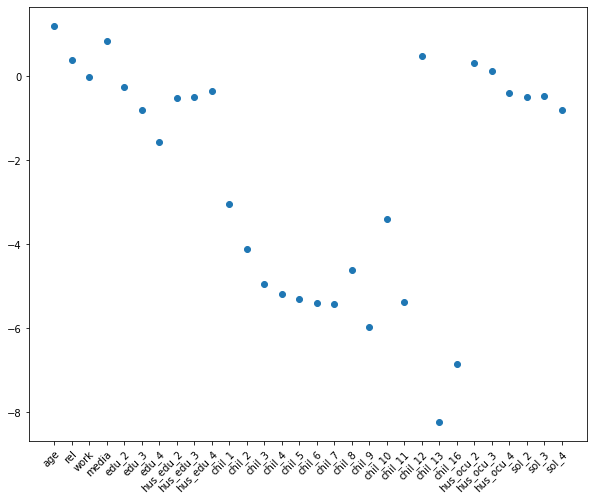

In [28]:
fig, ax = plt.subplots(figsize = [10,8])
ax.plot(coef_df.loc[1], 'bo')
ax.plot(coef_df.loc[2], 'go')
ax.plot(coef_df.loc[3], 'ro')
ax.set_title('Coefficients for Logistic Regression', fontdict = {'fontsize': 14})
ax.set_xlabel('Features', fontdict = {'fontsize': 12})
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor");

## Logistic Regression w/o Children dummied

{'lr__C': 4.281332398719396, 'lr__class_weight': 'balanced', 'lr__dual': True, 'lr__l1_ratio': 0.0001, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Classifier:  LogisticRegression
Num features:  17
Model score:  0.5420054200542005
Accuracy score:  0.5420054200542005
Model F1 (micro):  0.5420054200542005
Model F1 (macro):  0.5377689957700215
Model F1 (weighted):  0.542374234515247
Cross validation score:  [0.47297297 0.44594595 0.45945946 0.45945946 0.52054795]
Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.59      0.60       149
           2       0.51      0.55      0.53        93
           3       0.49      0.48      0.48       127

    accuracy                           0.54       369
   macro avg       0.54      0.54      0.54       369
weighted avg       0.54      0.54      0.54       369

One-vs-One ROC AUC scores:
0.713027 (macro),
0.712080 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712651 (macro),
0.7

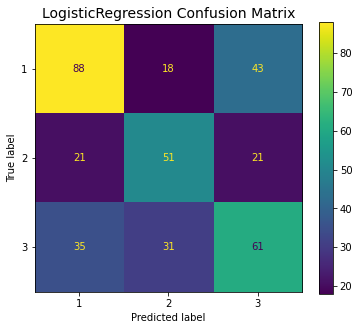

In [29]:
to_dummy = ['edu', 'hus_edu', 'hus_ocu', 'sol']
X_dums, X_train, X_test, y_train, y_test = dummy_transform_scale(X, y, to_dummy, rs = 729)
# set up pipeline
pipe_lr = Pipeline([('lr' , LogisticRegression(random_state=729, max_iter=200))])

params_grid_lr = {#'lr' : [LogisticRegression()],
                  'lr__penalty' : ['l2'],
                  'lr__class_weight' : ['balanced'],
                  'lr__dual' : [True],
                  'lr__solver' : ['liblinear'],
                  'lr__C' : np.logspace(-4, 4, 20),
                  'lr__l1_ratio' : np.logspace(-4, 4, 20)
                 }

lr_clf = GridSearchCV(pipe_lr, param_grid = params_grid_lr, cv = 5, verbose=0, n_jobs=-1)

# fit on data
lr_clf.fit(X_train, y_train)
print(lr_clf.best_params_)
best_lr_nochil_clf = lr_clf.best_estimator_
model_stats(X_dums.columns, best_lr_nochil_clf, 'LogisticRegression', X_test, y_test)

We will also investigate whether to bin `child` counts for values 12 and above.

## LogisticRegression w/ Children capped at 12, dummied

Classifier:  LogisticRegression
Num features:  28
Model score:  0.5745257452574526
Accuracy score:  0.5745257452574526
Model F1 (micro):  0.5745257452574526
Model F1 (macro):  0.5660260551248922
Model F1 (weighted):  0.5763221448428955
Cross validation score:  [0.44594595 0.47297297 0.54054054 0.55405405 0.43835616]
Classification Report:
              precision    recall  f1-score   support

           1       0.68      0.63      0.65       149
           2       0.49      0.53      0.51        93
           3       0.53      0.54      0.53       127

    accuracy                           0.57       369
   macro avg       0.57      0.57      0.57       369
weighted avg       0.58      0.57      0.58       369

One-vs-One ROC AUC scores:
0.749358 (macro),
0.751516 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.752777 (macro),
0.753711 (weighted by prevalence)


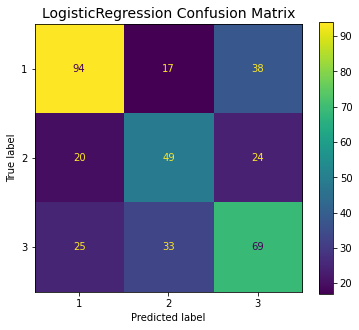

In [30]:
df_chil_cap = X.copy()
df_chil_cap['chil'] = np.where(df_chil_cap.chil > 11, 12, df_chil_cap.chil)
to_dummy = ['edu', 'hus_edu', 'chil', 'hus_ocu', 'sol']
X_dums, X_train, X_test, y_train, y_test = dummy_transform_scale(df_chil_cap, y, to_dummy, rs = 729)
lr_chil_cap_dum = LogisticRegression(random_state=729, max_iter=200,
                                     C = 4.281332398719396,
                                     class_weight = 'balanced',
                                     dual = True,
                                     l1_ratio = 0.0001,
                                     penalty = 'l2',
                                     solver = 'liblinear')
lr_chil_cap_dum.fit(X_train, y_train)
model_stats(X_dums.columns, lr_chil_cap_dum, 'LogisticRegression', X_test, y_test)

## LogisticRegression w/ Children capped at 12, not dummied

Classifier:  LogisticRegression
Num features:  17
Model score:  0.5420054200542005
Accuracy score:  0.5420054200542005
Model F1 (micro):  0.5420054200542005
Model F1 (macro):  0.5377689957700215
Model F1 (weighted):  0.542374234515247
Cross validation score:  [0.47297297 0.44594595 0.45945946 0.45945946 0.52054795]
Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.59      0.60       149
           2       0.51      0.55      0.53        93
           3       0.49      0.48      0.48       127

    accuracy                           0.54       369
   macro avg       0.54      0.54      0.54       369
weighted avg       0.54      0.54      0.54       369

One-vs-One ROC AUC scores:
0.713336 (macro),
0.712374 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712934 (macro),
0.708726 (weighted by prevalence)


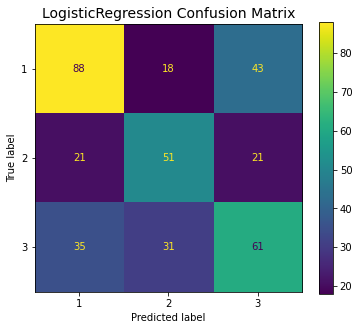

In [31]:
to_dummy = ['edu', 'hus_edu', 'hus_ocu', 'sol']
X_dums, X_train, X_test, y_train, y_test = dummy_transform_scale(df_chil_cap, y, to_dummy, rs = 729)
lr_chil_cap_nodum = LogisticRegression(random_state=729, max_iter=200,
                                     C = 4.281332398719396,
                                     class_weight = 'balanced',
                                     dual = True,
                                     l1_ratio = 0.0001,
                                     penalty = 'l2',
                                     solver = 'liblinear')
lr_chil_cap_nodum.fit(X_train, y_train)
model_stats(X_dums.columns, lr_chil_cap_nodum, 'LogisticRegression', X_test, y_test)

We see that capping child count at 12 is ideal.

In [32]:
X = df_chil_cap.copy()

## LogisticRegression GridSearchCV

{'lr__C': 206.913808111479, 'lr__class_weight': 'balanced', 'lr__dual': True, 'lr__l1_ratio': 0.0001, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Classifier:  LogisticRegression
Num features:  28
Model score:  0.5555555555555556
Accuracy score:  0.5555555555555556
Model F1 (micro):  0.5555555555555556
Model F1 (macro):  0.5450469086004128
Model F1 (weighted):  0.5566992298062968
Cross validation score:  [0.43243243 0.5        0.54054054 0.52702703 0.45205479]
Classification Report:
              precision    recall  f1-score   support

           1       0.66      0.60      0.63       149
           2       0.50      0.45      0.47        93
           3       0.49      0.57      0.53       127

    accuracy                           0.56       369
   macro avg       0.55      0.54      0.55       369
weighted avg       0.56      0.56      0.56       369

One-vs-One ROC AUC scores:
0.744383 (macro),
0.746267 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.747558 (macro),
0.7

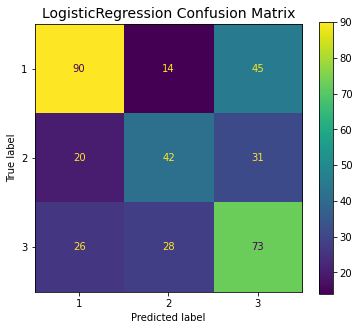

In [33]:
to_dummy = ['edu', 'hus_edu', 'chil', 'hus_ocu', 'sol']
X_dums, X_train, X_test, y_train, y_test = dummy_transform_scale(X, y, to_dummy, rs = 729)

# set up pipeline
pipe_lr = Pipeline([('lr' , LogisticRegression(random_state=729, max_iter = 500))])

params_grid_lr = {# 'lr' : [LogisticRegression()],
                  'lr__penalty' : ['l1', 'l2', 'elasticnet'],
                  'lr__class_weight' : ['balanced', 'none'],
                  'lr__dual' : [True, False],
                  'lr__solver' : ['lbfgs', 'liblinear'],
                  'lr__C' : np.logspace(-4, 4, 20),
                  'lr__l1_ratio' : np.logspace(-4, 4, 20)
                 }
lr_clf = GridSearchCV(pipe_lr, param_grid = params_grid_lr, cv = 5, verbose=0, n_jobs=-1)

# fit on data
lr_clf.fit(X_train, y_train)
print(lr_clf.best_params_)
best_lr_clf = lr_clf.best_estimator_
model_stats(X_dums.columns, best_lr_clf, 'LogisticRegression', X_test, y_test)

## KNN using Pipeline and OHE

In [34]:
cat_columns = ['edu', 'hus_edu', 'chil', 'hus_ocu', 'sol']
for col in cat_columns:
    X[col] = X[col].astype(object)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=729)

In [35]:
# train set
X_train_nums = X_train.select_dtypes('int64')

rs = RobustScaler()
# ss = StandardScaler()

rs.fit(X_train_nums)
nums_df = pd.DataFrame(rs.transform(X_train_nums),
                      index=X_train_nums.index)

X_train_cat = X_train.select_dtypes('object')

ohe = OneHotEncoder(
    drop='first',
    sparse=False)

dums = ohe.fit_transform(X_train_cat)
dums_df = pd.DataFrame(dums,
                       columns=ohe.get_feature_names(),
                       index=X_train_cat.index)

numerical_pipeline = Pipeline(steps=[
    ('rs', RobustScaler())
#     ('ss', StandardScaler())
])
                
categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder( #drop='first',
                         sparse=False,
                         handle_unknown='ignore'))
])

trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_train_nums.columns),
    ('categorical', categorical_pipeline, X_train_cat.columns)
])

{'knn__metric': 'euclidean', 'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}
Classifier:  KNeighborsClassifier
Num features:  30
Model score:  0.4993215739484396
Accuracy score:  0.4993215739484396
Model F1 (micro):  0.4993215739484396
Model F1 (macro):  0.4808999931621281
Model F1 (weighted):  0.49913818771626006
Cross validation score:  [0.43243243 0.51351351 0.45578231 0.46258503 0.46938776]
Classification Report:
              precision    recall  f1-score   support

           1       0.59      0.58      0.59       317
           2       0.43      0.38      0.40       167
           3       0.43      0.47      0.45       253

    accuracy                           0.50       737
   macro avg       0.48      0.48      0.48       737
weighted avg       0.50      0.50      0.50       737

One-vs-One ROC AUC scores:
0.676985 (macro),
0.678382 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.678261 (macro),
0.679559 (weighted by prevalence)


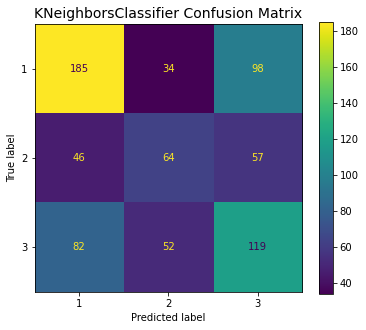

In [36]:
model_pipe = Pipeline(steps=[
    ('trans', trans),
    ('knn', KNeighborsClassifier())
])

params_grid_knn = {'knn__n_neighbors': [3, 5, 7, 9],
             'knn__p': [1, 2, 3],
             'knn__weights' : ['uniform', 'distance'],
             'knn__metric' : ['euclidean', 'manhattan', 'minkowski']
            }

knn_clf = GridSearchCV(model_pipe, param_grid = params_grid_knn,
                       cv = 3, verbose=0, n_jobs=-1)
knn_clf.fit(X_train, y_train)
print(knn_clf.best_params_)
best_knn_clf = knn_clf.best_estimator_
model_stats(X_train.columns, best_knn_clf, 'KNeighborsClassifier', X_test, y_test)

## SVM with PCA

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'pca__n_components': 5, 'svm__class_weight': 'balanced', 'svm__kernel': 'rbf'}
Classifier:  SVM
Num features:  30
Model score:  0.4816824966078697
Accuracy score:  0.4816824966078697
Model F1 (micro):  0.4816824966078697
Model F1 (macro):  0.48064182467584454
Model F1 (weighted):  0.48579192798021936
Cross validation score:  [0.50675676 0.50675676 0.4829932  0.5170068  0.52380952]
Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.43      0.50       317
           2       0.35      0.63      0.45       167
           3       0.53      0.45      0.49       253

    accuracy                           0.48       737
   macro avg       0.50      0.50      0.48       737
weighted avg       0.52      0.48      0.49       737

One-vs-One ROC AUC scores:
0.678986 (macro),
0.679513 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.680671 (macro),
0.679541 (weighted by pr

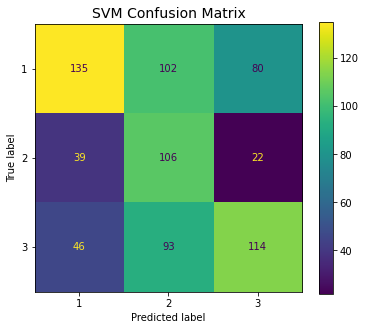

In [37]:
# using same X_train, X_test, y_train, y_test
pipe_svm = Pipeline([
                     ('scl', RobustScaler()),
                     ('pca', PCA()),
                     ('svm', SVC(random_state=42, probability=True))])

params_grid_svm = {'svm__class_weight' : ['balanced', 'none'],
                   'svm__kernel' : ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                   'pca__n_components': [0, 2, 5, 10, 15, 20, 30, 45, 64],
                 }

svm_clf = GridSearchCV(pipe_svm, param_grid = params_grid_svm,
                       cv = 5, verbose=1, n_jobs=-1)
svm_clf.fit(X_train, y_train)
print(svm_clf.best_params_)
best_svm_clf = svm_clf.best_estimator_
model_stats(X_train.columns, best_svm_clf, 'SVM', X_test, y_test)

## RandomForestClassifier GridSearchCV

{'rfc__max_depth': 7, 'rfc__max_features': 'sqrt', 'rfc__n_estimators': 50}
Classifier:  RandomForestClassifier
Num features:  30
Model score:  0.5427408412483039
Accuracy score:  0.5427408412483039
Model F1 (micro):  0.5427408412483039
Model F1 (macro):  0.5245937238467627
Model F1 (weighted):  0.5422353777951127
Cross validation score:  [0.55405405 0.54054054 0.46258503 0.51020408 0.53741497]
Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.59      0.61       317
           2       0.49      0.40      0.44       167
           3       0.48      0.58      0.52       253

    accuracy                           0.54       737
   macro avg       0.53      0.52      0.52       737
weighted avg       0.55      0.54      0.54       737

One-vs-One ROC AUC scores:
0.719555 (macro),
0.722893 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.724410 (macro),
0.726204 (weighted by prevalence)


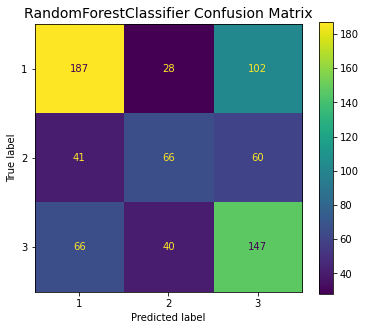

In [38]:
# using same X_train, X_test, y_train, y_test
pipe_rfc = Pipeline([('rfc' , RandomForestClassifier())])

params_grid_rfc = {#'rfc' : [RandomForestClassifier()],
                   'rfc__n_estimators' : list(range(10,101,10)),
                   'rfc__max_features': ['auto', 'sqrt', 'log2'],
                   'rfc__max_depth' : list(range(1,10))
                  }

rfc_clf = GridSearchCV(pipe_rfc, param_grid = params_grid_rfc, cv = 5, verbose=0, n_jobs=-1)

rfc_clf.fit(X_train, y_train)
print(rfc_clf.best_params_)
best_rfc_clf = rfc_clf.best_estimator_
model_stats(X_train.columns, best_rfc_clf, 'RandomForestClassifier', X_test, y_test)

## LogisticRegression GridSearchCV with Tomek Links resampling

In [39]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train.ravel())
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 263, 3: 205, 2: 166})


{'lr__C': 0.03359818286283781, 'lr__class_weight': 'balanced', 'lr__dual': False, 'lr__l1_ratio': 0.0001, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}
Classifier:  LogisticRegression
Num features:  30
Model score:  0.4993215739484396
Accuracy score:  0.4993215739484396
Model F1 (micro):  0.4993215739484396
Model F1 (macro):  0.49715532104851334
Model F1 (weighted):  0.5045185066522773
Cross validation score:  [0.47972973 0.50675676 0.55102041 0.50340136 0.53061224]
Classification Report:
              precision    recall  f1-score   support

           1       0.68      0.45      0.54       317
           2       0.38      0.59      0.47       167
           3       0.47      0.50      0.49       253

    accuracy                           0.50       737
   macro avg       0.51      0.51      0.50       737
weighted avg       0.54      0.50      0.50       737

One-vs-One ROC AUC scores:
0.694519 (macro),
0.693361 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.692960 (macro),
0.

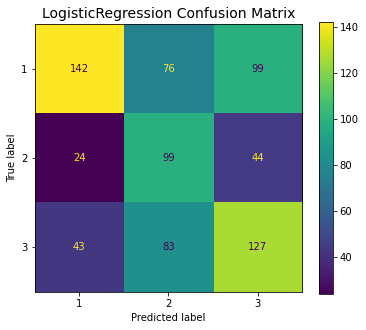

In [40]:
# Create grid search object
lr_tl_clf = GridSearchCV(pipe_lr, param_grid = params_grid_lr, cv = 5, verbose=0, n_jobs=-1)

# Fit on data
lr_tl_clf.fit(X_res, y_res)
print(lr_tl_clf.best_params_)
best_lr_tl_clf = lr_tl_clf.best_estimator_
model_stats(X_train.columns, best_lr_tl_clf, 'LogisticRegression', X_test, y_test)

## RandomForestClassifier GridSearchCV with Tomek Links resampling

{'rfc__max_depth': 8, 'rfc__max_features': 'log2', 'rfc__n_estimators': 10}
Classifier:  RandomForestClassifier
Num features:  30
Model score:  0.5373134328358209
Accuracy score:  0.5373134328358209
Model F1 (micro):  0.5373134328358209
Model F1 (macro):  0.5234534569610908
Model F1 (weighted):  0.5407303258275038
Cross validation score:  [0.52027027 0.52027027 0.46938776 0.52380952 0.53061224]
Classification Report:
              precision    recall  f1-score   support

           1       0.66      0.59      0.63       317
           2       0.43      0.47      0.45       167
           3       0.48      0.51      0.49       253

    accuracy                           0.54       737
   macro avg       0.52      0.53      0.52       737
weighted avg       0.55      0.54      0.54       737

One-vs-One ROC AUC scores:
0.700150 (macro),
0.703258 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.704783 (macro),
0.706111 (weighted by prevalence)


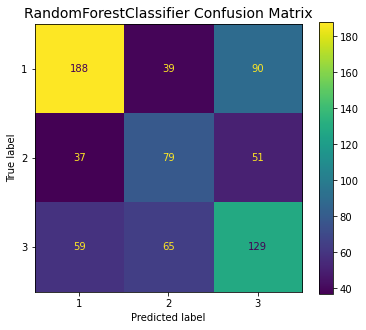

In [41]:
# Create grid search object
rfc_tl_clf = GridSearchCV(pipe_rfc, param_grid = params_grid_rfc, cv = 5, verbose=0, n_jobs=-1)

# Fit on data
rfc_tl_clf.fit(X_res, y_res)
print(rfc_tl_clf.best_params_)
best_rfc_tl_clf = rfc_tl_clf.best_estimator_
model_stats(X_train.columns, best_rfc_tl_clf, 'RandomForestClassifier', X_test, y_test)

## XGBoost Classifier

Using defaults

Classifier:  XGBClassifier
Num features:  30
Model score:  0.5365853658536586
Accuracy score:  0.5365853658536586
Model F1 (micro):  0.5365853658536586
Model F1 (macro):  0.5126983217824618
Model F1 (weighted):  0.5287381307285781
Cross validation score:  [0.45945946 0.32432432 0.41891892 0.40540541 0.38356164]
Classification Report:
              precision    recall  f1-score   support

           1       0.57      0.67      0.62       149
           2       0.49      0.34      0.41        93
           3       0.52      0.52      0.52       127

    accuracy                           0.54       369
   macro avg       0.53      0.51      0.51       369
weighted avg       0.53      0.54      0.53       369

One-vs-One ROC AUC scores:
0.700474 (macro),
0.703664 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.704873 (macro),
0.708515 (weighted by prevalence)


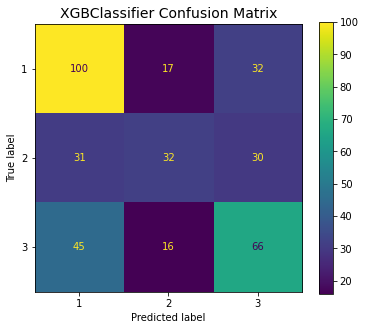

In [44]:
to_dummy = ['edu', 'hus_edu', 'chil', 'hus_ocu', 'sol']
X_dums, X_train, X_test, y_train, y_test = dummy_transform_scale(X, y, to_dummy, rs = 729)

xgb = XGBClassifier(random_state=729, learning_rate = 0.2, eval_metric = 'auc')
xgb.fit(X_train, y_train)
model_stats(X_dums.columns, xgb, 'XGBClassifier', X_test, y_test)

## XGBClassifier with GridSearchCV

In [ ]:
pipe_xgb = Pipeline([('xgb', XGBClassifier(random_state=729, learning_rate = 0.2, eval_metric = 'auc'))])
params_grid_xgb = {'xgb__nthread': [4],
                   'xgb__booster' : ['gbtree', 'gblinear', 'dart'],
                   'xgb__colsample_bylevel': [0.5, 0.75],
                   'xgb__colsample_bynode': [0.5, 0.75],
                   'xgb__colsample_bytree': [0.5, 0.75],
                   #'xgb__learning_rate': np.linspace(0.1, 0.2, 6), # does not need
                   'xgb__max_depth': [8, 10],
                   'xgb__min_child_weight': [7, 9],
                   'xgb__missing': [-999],
                   'xgb__n_estimators': [250],
                   #'xgb__objective': ['reg:squarederror'],
                   'xgb__subsample': [0.2, 0.5, 0.7]
                  }
xgb_clf = GridSearchCV(pipe_xgb, params_grid_xgb, n_jobs=-1,
                  cv=StratifiedKFold(n_splits=3, shuffle=True), 
                  scoring='f1_weighted',
                  verbose=2, refit=True)
xgb_clf.fit(X_train, y_train)
print(xgb_clf.best_params_)
best_xgb_clf = xgb_clf.best_estimator_
model_stats(X_dums.columns, best_xgb_clf, 'XGBClassifier', X_test, y_test)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


## XGBClassifier with GridSearchCV - further tuning

In [ ]:
pipe_xgb = Pipeline([('xgb', XGBClassifier(random_state=729, learning_rate = 0.3, eval_metric = 'auc'))])
params_grid_xgb = {'xgb__nthread': [4],
                   'xgb__booster' : ['gbtree', 'gblinear', 'dart'],
                   'xgb__colsample_bylevel': [0.25, 0.4, 0.5],
                   'xgb__colsample_bynode': [0.25, 0.5, 0.75],
                   'xgb__colsample_bytree': [0.25, 0.5, 0.75],
                   #'xgb__learning_rate': np.linspace(0.1, 0.2, 6), # does not need
                   'xgb__max_depth': [5, 6, 7, 8], # 7,8,10
                   'xgb__min_child_weight': [4, 5, 6, 7], # 5,6,7,9
                   'xgb__missing': [-999],
                   'xgb__n_estimators': [100, 250],
                   #'xgb__objective': ['reg:squarederror'],
                   'xgb__subsample': [0.1, 0.15, 0.2] # 0.15, 0.2, 0.5, 0.7
                  }
xgb_clf = GridSearchCV(pipe_xgb, params_grid_xgb, n_jobs=-1,
                  cv=StratifiedKFold(n_splits=3, shuffle=True), 
                  scoring='f1_weighted',
                  verbose=2, refit=True)
xgb_clf.fit(X_train, y_train)
print(xgb_clf.best_params_)
best_xgb_clf = xgb_clf.best_estimator_
model_stats(X_dums.columns, best_xgb_clf, 'XGBClassifier', X_test, y_test)

## XGBoost Random Forest Classifier

Using defaults

In [ ]:
xgb = XGBRFClassifier(random_state=729, learning_rate = 0.2, eval_metric = 'auc')
xgb.fit(X_train, y_train)
model_stats(X_dums.columns, xgb, 'XGBRFClassifier', X_test, y_test)

# Using updated features, binary classification, and optimizing for Recall score

In [ ]:
# Cleaning: capping maximum children down to 12
df['chil'] = np.where(df.chil > 11,
                     12,
                     df.chil)

# FE: creating a feature that represents a binary for if wife's education is higher than husband's
df['wife_more_edu'] = np.where(df.edu >= df.hus_edu,
                              1,
                              0)

# FE: creating a feature that represents a binary for women who's education level is the lowest possible while also being not employed.
df['neet'] = np.where((df.edu == 1) 
                    & (df.work == 1),
                         1,
                         0)
# here we set a binary copy of our primary df, for use wherever we want to see ...
y_df = df.copy() # ... any contraceptive use vs. no contraceptive use
y_df['uses_cm'] = np.where(df.cmc == 1, 
                            0, 
                            1)

X = df.copy().drop(columns = 'cmc')
y = y_df.pop('uses_cm')

In [ ]:
to_dummy = ['edu', 'hus_edu', 'chil', 'hus_ocu', 'sol']
X_dums, X_train, X_test, y_train, y_test = dummy_transform_scale(X, y, to_dummy, rs = 729)

In [ ]:
pipe_xgb = Pipeline([('xgb', XGBClassifier(random_state=729, learning_rate = 0.3, eval_metric = 'auc'))])
params_grid_xgb = {'xgb__nthread': [4],  # not a stat
                   'xgb__booster' : ['gbtree', 'gblinear', 'dart'],
                   'xgb__colsample_bylevel': [0.25, 0.5],
                   'xgb__colsample_bynode': [0.25, 0.5],
                   'xgb__colsample_bytree': [0.25, 0.5],
                   #'xgb__learning_rate': np.linspace(0.1, 0.2, 6), # does not need
                   'xgb__max_depth': [5, 6, 7], # 7,8,10
                   'xgb__min_child_weight': [5, 6, 7], # 5,6,7,9
                   'xgb__missing': [-999],
                   'xgb__n_estimators': [100, 250],
                   #'xgb__objective': ['reg:squarederror'],
                   'xgb__subsample': [0.05, 0.1] # 0.15, 0.2, 0.5, 0.7
                  }
xgb_clf = GridSearchCV(pipe_xgb, params_grid_xgb, n_jobs=-1,
                  cv=StratifiedKFold(n_splits=3, shuffle=True), 
                  scoring='recall',
                  verbose=2, refit=True)
xgb_clf.fit(X_train, y_train)
print(xgb_clf.best_params_)
best_xgb_clf = xgb_clf.best_estimator_
model_stats(X_dums.columns, best_xgb_clf, 'XGBClassifier', X_test, y_test, True)